In [1]:
import glob
import importlib
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import MDAnalysis as mda
import mdtraj as md
import numpy as np
import prettypyplot as pplt
import pyemma
import seaborn as sns
from matplotlib import ticker
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis

import extq
import ivac

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [2]:
sys.path.insert(1, "../../python")
import plotting
import util

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [5]:
from joblib import Parallel, delayed
from multiprocess import cpu_count

n_jobs = cpu_count()

In [6]:
HOME_DIR = "/project/dinner/scguo/ci-vsd"

In [8]:
u = mda.Universe("../../civsd-pro.psf", "../../anton2/prot/civsd.prot.3.xtc")

In [62]:
for a in u.select_atoms("protein and resid 216 and name HN"):
    print(a)

<Atom 1761: HN of type H of resname GLY, resid 216 and segid A>


In [59]:
def hbond_310(trajfile, resid):
    u = mda.Universe(f"{HOME_DIR}/civsd-pro.psf", trajfile)
    acceptor_sel = f"protein and resid {resid} and name O"
    donor_310_sel = f"protein and resid {resid + 4} and name N"
    hyd_310_sel = f"protein and resid {resid + 4} and name HN"
    hbonds = HydrogenBondAnalysis(
        universe=u,
        donors_sel=donor_310_sel,
        hydrogens_sel=hyd_310_sel,
        acceptors_sel=acceptor_sel,
        update_selections=False,
        d_a_cutoff=3.5,
        d_h_a_angle_cutoff=120,
    )
    return hbonds

def hbond_alpha(trajfile, resid):
    u = mda.Universe(f"{HOME_DIR}/civsd-pro.psf", trajfile)
    acceptor_sel = f"protein and resid {resid} and name O"
    donor_alpha_sel = f"protein and resid {resid + 3} and name N"
    hydr_alpha_sel = f"protein and resid {resid + 3} and name HN"
    hbonds = HydrogenBondAnalysis(
        universe=u,
        donors_sel=donor_alpha_sel,
        hydrogens_sel=hydr_alpha_sel,
        acceptors_sel=acceptor_sel,
        update_selections=False,
        d_a_cutoff=3.5,
        d_h_a_angle_cutoff=120,
    )
    return hbonds

def hbond_helix(trajfile):
    u = mda.Universe(f"{HOME_DIR}/civsd-pro.psf", trajfile)
    acceptor_sel = f"protein and resid 216 to 232 and name O"
    donor_sel = f"protein and resid 219 to 236 and name N"
    hydr_sel = f"protein and resid 219 to 236 and name HN"
    hbonds = HydrogenBondAnalysis(
        universe=u,
        donors_sel=donor_sel,
        hydrogens_sel=hydr_sel,
        acceptors_sel=acceptor_sel,
        update_selections=False,
        d_a_cutoff=3.5,
        d_h_a_angle_cutoff=120,
    )
    return hbonds

def run_analysis(analysis):
    analysis.run()
    trajlen = len(analysis.frames)
    ans_310 = np.zeros((trajlen, 17), dtype=bool)
    ans_alpha = np.zeros((trajlen, 17), dtype=bool)
    for (frame, donor, _, acceptor, _, _) in analysis.results.data['hbonds']:
        frame = int(frame)
        donor_resid = u.atoms[int(donor)].residue.resid
        acceptor_resid = u.atoms[int(acceptor)].residue.resid
        if donor_resid == acceptor_resid + 3:
            ans_310[frame, acceptor_resid - 216] = True
        elif donor_resid == acceptor_resid + 4:
            ans_alpha[frame, acceptor_resid - 216] = True
    return ans_310, ans_alpha

In [17]:
dcds = []
for i in range(3, 119):
    if i == 82:
        continue
    dcds.append(f"{HOME_DIR}/anton2/prot/civsd.prot.{i}.xtc")
print(len(dcds))

115


In [35]:
for (i, j, k, count) in hbond.count_by_ids():
    print(u.atoms[i].residue.resid, u.atoms[k].residue.resid, count)

222 218 9967
233 229 9961
231 227 9927
235 231 9914
232 228 9912
230 226 9911
225 221 9893
236 232 9870
224 220 9773
229 225 9770
228 224 9617
223 219 9593
221 217 9564
234 230 9550
227 223 8212
226 222 7860
220 216 7365
219 216 3295
226 223 2832
227 224 2555
224 221 1172
225 222 905
220 217 872
223 220 858
228 225 849
232 229 779
229 226 697
231 228 625
221 218 528
234 231 515
222 219 510
230 227 504
235 232 432
233 230 431


In [53]:
# shape (n_frames, n_res)
ans_310 = np.zeros((10001, 17), dtype=bool)
ans_alpha = np.zeros((10001, 17), dtype=bool)
for (frame, donor, _, acceptor, _, _) in hbond.results.data['hbonds']:
    frame = int(frame)
    donor_resid = u.atoms[int(donor)].residue.resid
    acceptor_resid = u.atoms[int(acceptor)].residue.resid
    if donor_resid == acceptor_resid + 3:
        ans_310[frame, acceptor_resid - 216] = True
    elif donor_resid == acceptor_resid + 4:
        ans_alpha[frame, acceptor_resid - 216] = True

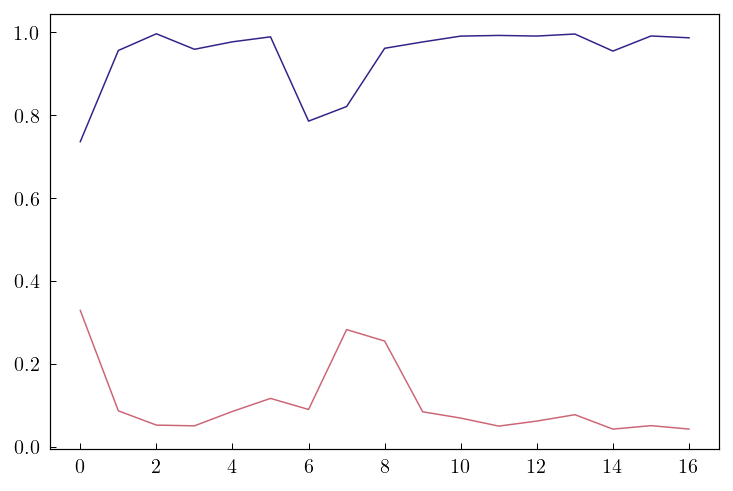

In [55]:
plt.plot(np.mean(ans_310, axis=0))
plt.plot(np.mean(ans_alpha, axis=0))

In [60]:
test = run_analysis(hbond_helix(dcds[0]))

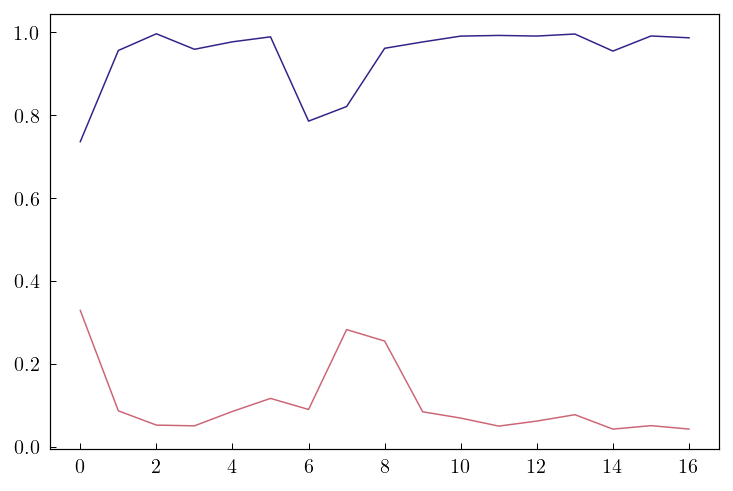

In [61]:
plt.plot(np.mean(test[0], axis=0))
plt.plot(np.mean(test[1], axis=0))

In [63]:
analysis_ensemble = [hbond_helix(f) for f in dcds]
results = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble
)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils V

In [75]:
print(mda.lib.util.convert_aa_code(u.residues[110].resname))
print(u.residues[110].resid)

G
216


([<matplotlib.axis.XTick at 0x7f4a98fff250>,
 [Text(0, 0, 'G216'),
  Text(1, 0, 'R217'),
  Text(2, 0, 'L218'),
  Text(3, 0, 'V219'),
  Text(4, 0, 'V220'),
  Text(5, 0, 'L221'),
  Text(6, 0, 'A222'),
  Text(7, 0, 'R223'),
  Text(8, 0, 'L224'),
  Text(9, 0, 'L225'),
  Text(10, 0, 'R226'),
  Text(11, 0, 'V227'),
  Text(12, 0, 'V228'),
  Text(13, 0, 'R229'),
  Text(14, 0, 'L230'),
  Text(15, 0, 'A231'),
  Text(16, 0, 'R232')])

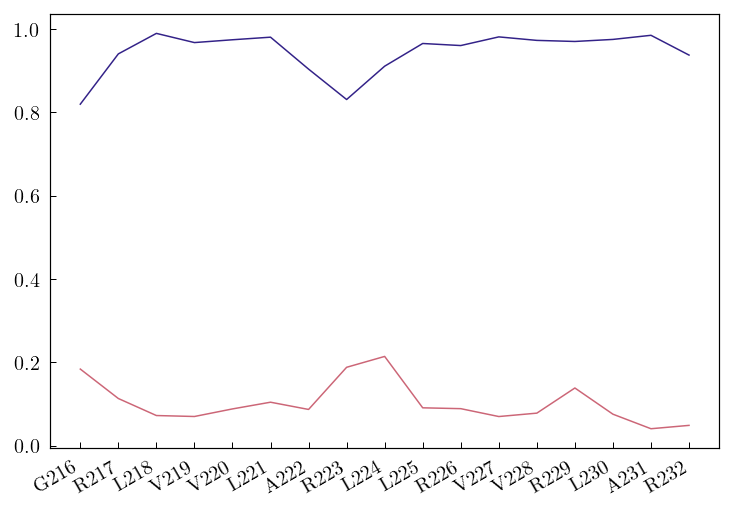

In [81]:
results_310 = [r[0] for r in results]
results_alpha = [r[1] for r in results]
plt.plot(np.mean(np.concatenate(results_310), axis=0))
plt.plot(np.mean(np.concatenate(results_alpha), axis=0))
resnames = [f"{mda.lib.util.convert_aa_code(res.resname)}{res.resid}" for res in u.residues[110:127]]
plt.xticks(range(0, 17), resnames, rotation=30, ha='right')

In [82]:
remove = {1282,
    1283,
    1284,
    1285,
    1286,
    1288,
    1289,
    1290,
    1187,
    1188,
    1189,
    1190,
    1191,
    1197,
    1198,
    1199,
    1203,
    1205,
    1206,
    1207,
    1211,
    1212,
    1213,
    1214,
    1215,
    1225,
    1226,
    1227,
    1228,
    1231,
    1232,
    1233,
    1236,
    1237,
    1238,
    1242,
    1245,
    1246,
    1252,
    1253,
    1260,
    1261,
    1262,
    1263,
    1266,
    1267,
    1268,
    1269,
    1270,
    1271,
    1272,
    1273,
    1274,
    1275,
    1276,
    1277,
    1278,
    1279,
}
files = []
for i in range(295):
    if (i + 1000) not in remove:
        files.append(f"/project/dinner/scguo/anton-old/xtc1000ns/civsd-{i}.xtc")

In [84]:
analysis_ensemble = [hbond_helix(f) for f in files]
results_old = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble
)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netc

In [85]:
# results_310 = [r[0] for r in results]
# results_alpha = [r[1] for r in results]
results_310_old = [r[0] for r in results_old]
results_alpha_old = [r[1] for r in results_old]
np.save("../../data/raw_feat/310_propensity_anton2", results_310)
np.save("../../data/raw_feat/alpha_propensity_anton2", results_alpha)
np.save("../../data/raw_feat/310_propensity", results_310_old)
np.save("../../data/raw_feat/alpha_propensity", results_alpha_old)

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


([<matplotlib.axis.XTick at 0x7f4a73838a90>,
 [Text(0, 0, 'G216'),
  Text(1, 0, 'R217'),
  Text(2, 0, 'L218'),
  Text(3, 0, 'V219'),
  Text(4, 0, 'V220'),
  Text(5, 0, 'L221'),
  Text(6, 0, 'A222'),
  Text(7, 0, 'R223'),
  Text(8, 0, 'L224'),
  Text(9, 0, 'L225'),
  Text(10, 0, 'R226'),
  Text(11, 0, 'V227'),
  Text(12, 0, 'V228'),
  Text(13, 0, 'R229'),
  Text(14, 0, 'L230'),
  Text(15, 0, 'A231'),
  Text(16, 0, 'R232')])

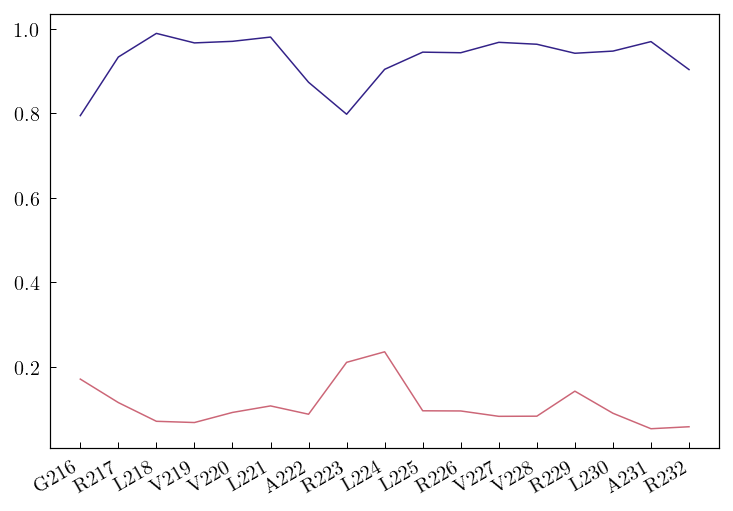

In [89]:
r_310 = np.concatenate((*results_310_old, *results_310))
r_alpha = np.concatenate((*results_alpha_old, *results_alpha))
plt.plot(np.mean(r_310, axis=0))
plt.plot(np.mean(r_alpha, axis=0))
plt.xticks(range(0, 17), resnames, rotation=30, ha='right')

# Plot by committor value

In [91]:
qp_du = np.load(f"../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8] # 50 ns lag time

In [92]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

In [93]:
steps, q_inds = bin_inds(qp_du)

In [94]:
q_data_alpha = []
q_data_310 = []
for idxs in q_inds:
    q_data_alpha.append(np.mean(r_alpha[idxs], axis=0))
    q_data_310.append(np.mean(r_310[idxs], axis=0))
q_data_alpha = np.array(q_data_alpha)
q_data_310 = np.array(q_data_310)

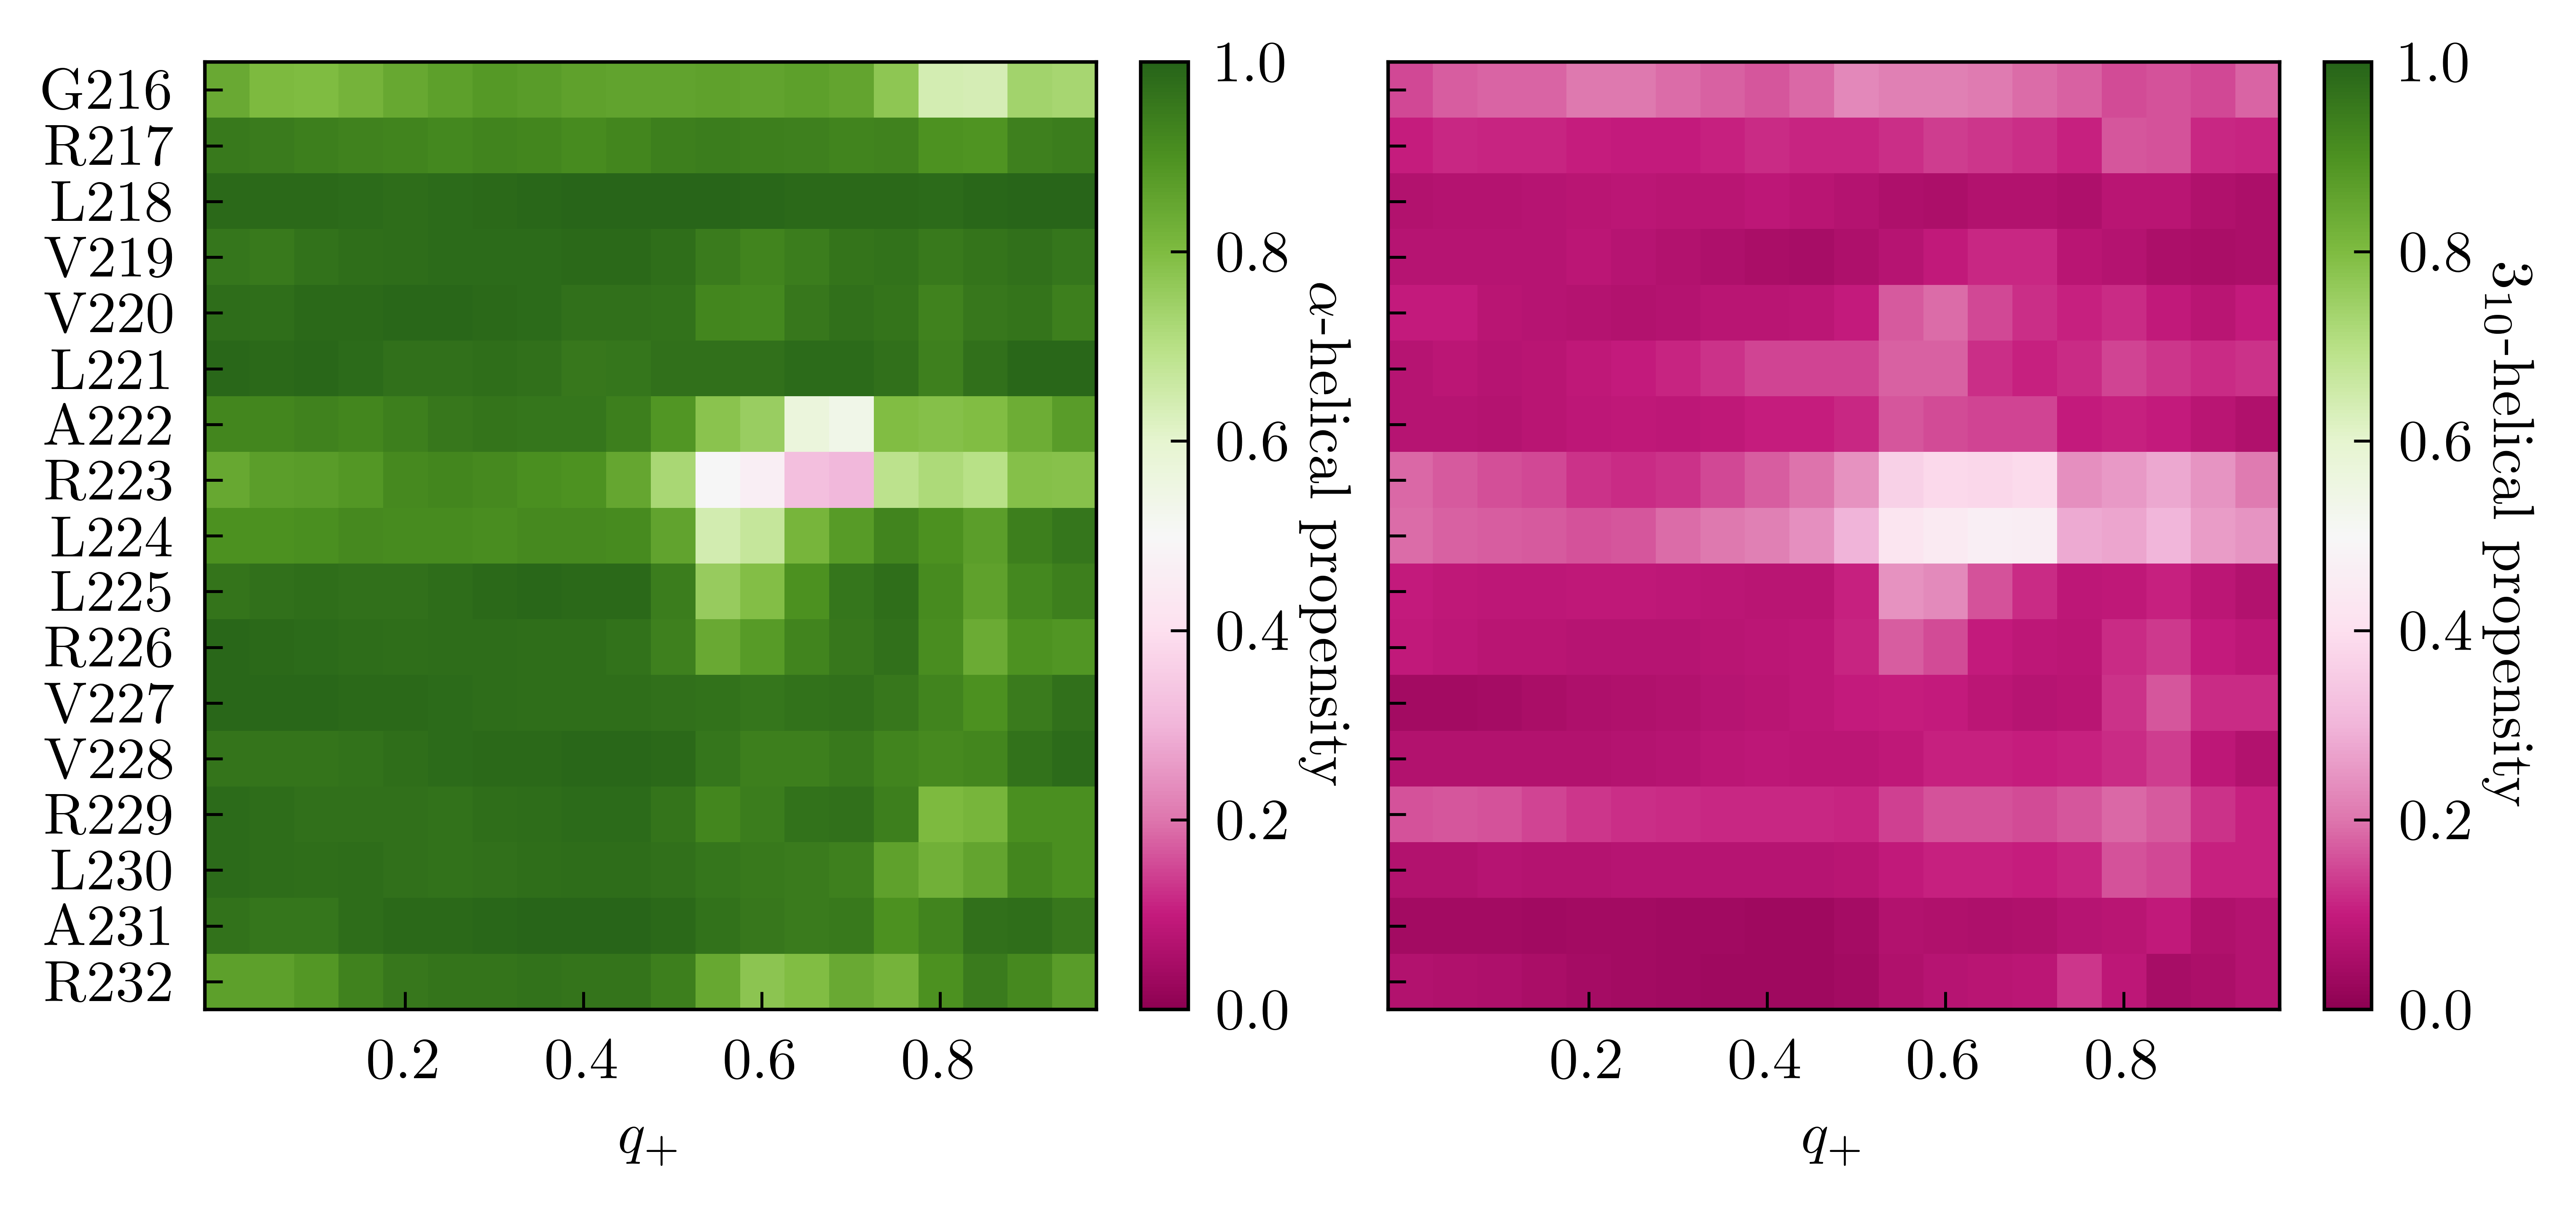

In [120]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(6.0, 2.75), dpi=500, constrained_layout=True)
h = ax0.imshow(q_data_alpha.T, aspect='auto', vmin=0, vmax=1, cmap='PiYG')
cb0 = plt.colorbar(h, ax=ax0)
cb0.set_label(r"$\alpha$-helical propensity", rotation=-90, labelpad=10)
h = ax1.imshow(q_data_310.T, aspect='auto', vmin=0, vmax=1, cmap='PiYG')
cb1 = plt.colorbar(h, ax=ax1)
cb1.set_label(r"$3_{10}$-helical propensity", rotation=-90, labelpad=10)

xlabels = [0.2, 0.4, 0.6, 0.8]
for ax in (ax0, ax1):
    ax.set_xticks(np.arange(4, 20, 4), xlabels)
    ax.set_yticks(range(0, 17), resnames, ha='right')
    ax.set_xlabel("$q_+$")
    ax.label_outer()
plt.savefig("../figures/helical-propensity.pdf")